# M1 Acitvidad
##### **Andres Eduardo Nowak de Anda** A01638430

In [1]:
# Model design
import agentpy as ap
from random import randint as rnd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import copy
from time import time

## About the model

This a model designed to clean up trash from a room

## Model definition

In [2]:
moves = [(0, 1), (1, 0), (1, 1), (0, -1), (-1, 0), (-1, -1), (-1, 1), (1, -1)]

total_moves = 0

start = 0

class Cleaner(ap.Agent):
    
    def setup(self):  
        self.condition = 0  # cleaner = 0
        self.grid_width = 0
        self.grid_height = 0
        
    def move(self):
        global total_moves
        
        pos = self.room.positions[self]
        moves_cp = moves.copy()
        
        agents = self.room.agents[pos[0], pos[1]]

        flag = True

        # check if there is dirt
        for x in agents:
            if(x.condition == 1): 
                x.condition = None
                flag = False
            #print(x)

        #print("end")
        
        # if there is no dirt move
        while(flag and len(moves_cp) > 0):
            rand_pos = rnd(0, len(moves_cp) - 1)
            move = moves_cp.pop(rand_pos)
            
            new_pos = tuple(map(sum, zip(pos, move)))
            
            if(new_pos[0] < self.grid_height and new_pos[0] >= 0 and 
               new_pos[1] < self.grid_width and new_pos[1] >= 0):

                self.room.move_by(self, moves[rand_pos])
                           
                total_moves += 1
                
                break # finish while loop


class CleanUpModel(ap.Model):
    
    def setup(self):
        global total_moves
        total_moves = 0
        # Create agents (cleaners and dirt) 
        n_dirt = int(self.p['Dirty density'] * (self.p.width * self.p.height))
        cleaners = self.agents = ap.AgentList(self, int(self.p['cleaners']), Cleaner)
        space = self.dirts = ap.AgentList(self, n_dirt)
        
        # Create grid (room)
        self.room = self.agents.room = ap.Grid(self, [self.p.height, self.p.width], track_empty=True)      
        self.room.add_agents(cleaners, positions=[(0, 0) for i in range(0, int(self.p['cleaners']))], random=False, empty=True)
        self.room.add_agents(space, random=True, empty=True)
        
        # Initiate a dynamic variable for all agents
        # Condition 0: cleaner, 1: dirty, 2: clean
        cleaners.condition = 0 
        cleaners.grid_width = self.p.width
        cleaners.grid_height = self.p.height
        
        space.condition = 1
        
        
        global start
        start = time()
        
        
    def step(self):
        dirt = self.agents.select(self.dirts.condition == 1)
        cleaners = self.agents.select(self.agents.condition == 0)

        for cleaner in cleaners:
            pos = self.room.positions[cleaner]
            
            cleaner.move()
        
        # Stop simulation if no Dirt is left
        if len(dirt) == 0: 
            self.stop()
            
    def end(self):        
        global total_moves
        end = time() # end time
        
        # Document a measure at the end of the simulation
        removed_dirt = len(self.agents.select(self.dirts.condition == None))
        
        self.report('Percentage of dirt removed', 
                    removed_dirt / len(self.dirts))
        self.report('Total moves', total_moves)
        self.report('Total time', end - start)

## Single-run animation

In [3]:
# Define parameters

parameters = {
    'Dirty density': 0.2, # Percentage of grid covered by dirt
    'width': 25,
    'height': 20,
    'cleaners': 50,
    'steps': 100,
}

In [4]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.room.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a clean up of a room\n"
                 f"Time-step: {model.t}, Dirt left: "
                 f"{len(model.agents.select(model.dirts.condition == 1))}")

fig, ax = plt.subplots() 
model = CleanUpModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))

## Parameter sweep (first is by dirt density and the second is by amount of cleaners

### By amount of dirt density

In [5]:
# Prepare parameter sample
parameters = {
    'Dirty density': ap.Range(0.2, 0.6), 
    'width': 20,
    'height': 20,
    'cleaners': 50,
}
sample = ap.Sample(parameters, n=20)

In [6]:
# Perform experiment
exp = ap.Experiment(CleanUpModel, sample, iterations=40)
results = exp.run()

Scheduled runs: 800
Completed: 800, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:04:06.488863


In [7]:
# Save and load data
results.save()
results = ap.DataDict.load('CleanUpModel')

Data saved to ap_output/CleanUpModel_9
Loading from directory ap_output/CleanUpModel_9/
Loading parameters_constants.json - Successful
Loading parameters_sample.csv - Successful
Loading info.json - Successful
Loading reporters.csv - Successful
Loading parameters_log.json - Successful


<AxesSubplot:xlabel='Dirty density', ylabel='Percentage of dirt removed'>

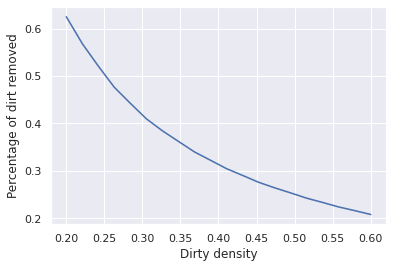

In [8]:
# Plot sensitivity
sns.set_theme()
sns.lineplot(
    data=results.arrange_reporters(), 
    x='Dirty density', 
    y='Percentage of dirt removed'
)

<AxesSubplot:xlabel='Dirty density', ylabel='Total moves'>

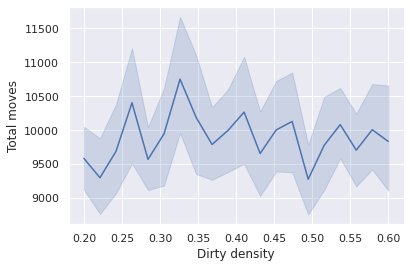

In [9]:
sns.lineplot(
    data=results.arrange_reporters(), 
    x='Dirty density', 
    y='Total moves'
)

<AxesSubplot:xlabel='Dirty density', ylabel='Total time'>

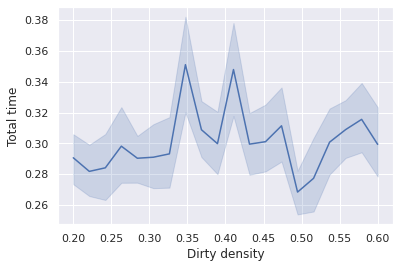

In [10]:
sns.lineplot(
    data=results.arrange_reporters(), 
    x='Dirty density', 
    y='Total time'
)

### By amount of cleaners

In [11]:
parameters = {
    'Dirty density': 0.4, 
    'width': 20,
    'height': 20,
    'cleaners': ap.Range(10, 50),
}
sample = ap.Sample(parameters, n=30)

In [12]:
# Perform experiment
exp = ap.Experiment(CleanUpModel, sample, iterations=50)
results = exp.run()

Scheduled runs: 1500
Completed: 1500, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:04:58.361939


In [13]:
# Save and load data
results.save()
results = ap.DataDict.load('CleanUpModel')

Data saved to ap_output/CleanUpModel_10
Loading from directory ap_output/CleanUpModel_10/
Loading parameters_constants.json - Successful
Loading parameters_sample.csv - Successful
Loading info.json - Successful
Loading reporters.csv - Successful
Loading parameters_log.json - Successful


<AxesSubplot:xlabel='cleaners', ylabel='Percentage of dirt removed'>

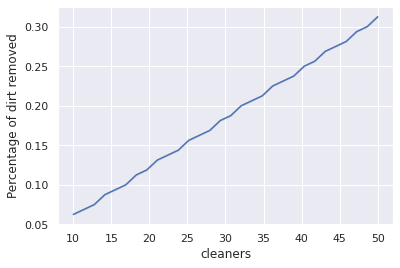

In [14]:
sns.lineplot(
    data=results.arrange_reporters(), 
    x='cleaners', 
    y='Percentage of dirt removed'
)

<AxesSubplot:xlabel='cleaners', ylabel='Total moves'>

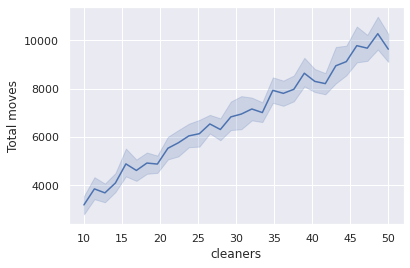

In [15]:
sns.lineplot(
    data=results.arrange_reporters(), 
    x='cleaners', 
    y='Total moves'
)

<AxesSubplot:xlabel='cleaners', ylabel='Total time'>

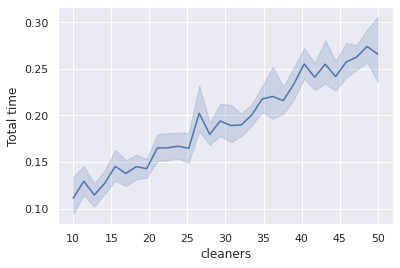

In [16]:
sns.lineplot(
    data=results.arrange_reporters(), 
    x='cleaners', 
    y='Total time'
)

# Total time is in s